<a href="https://colab.research.google.com/github/Sohankumar6/Final_Project_MRI/blob/main/brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

# Importing libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

Mounted at /content/drive


In [2]:
# Defining testing and training path
directory_path = '/content/drive/MyDrive/Final project'
testing_path = directory_path + '/Testing'
training_path = directory_path + '/Training'

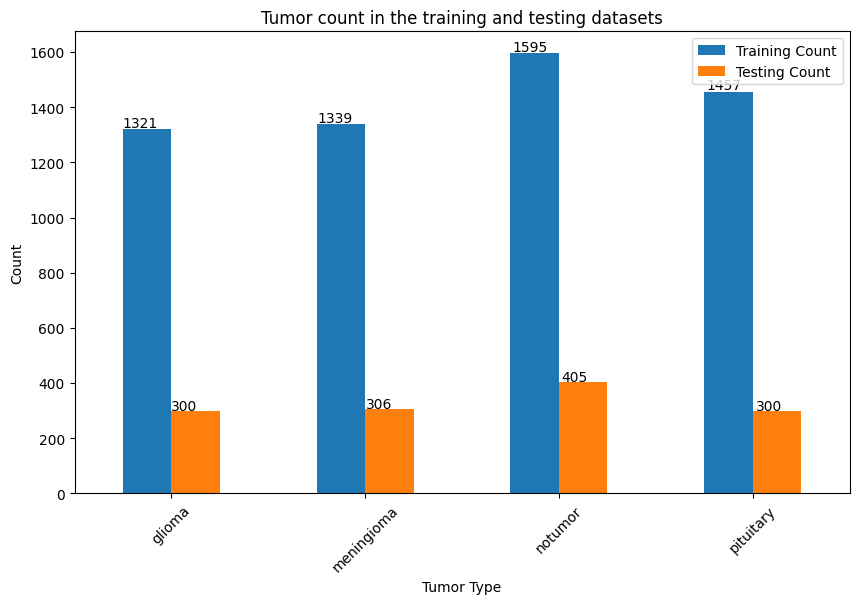

In [3]:
def load_images(dir_path):
    """
    Function to load images from directory
    """
    image_count_dict = {}
    image_paths = []
    image_labels = []
    for class_image_dir in os.listdir(dir_path):
        class_image_path = os.path.join(dir_path, class_image_dir)
        if os.path.isdir(class_image_path):
            image_count_dict[class_image_dir] = len(os.listdir(class_image_path))
            for image_name in os.listdir(class_image_path):
                image_paths.append(os.path.join(class_image_path, image_name))
                image_labels.append(class_image_dir)
    return image_count_dict, image_paths, image_labels

training_count, training_image_paths, training_labels = load_images(training_path)
testing_count, testing_image_paths, testing_labels = load_images(testing_path)

train_data_df = pd.DataFrame(list(training_count.items()), columns=['Tumor Type', 'Training Count'])
test_data_df = pd.DataFrame(list(testing_count.items()), columns=['Tumor Type', 'Testing Count'])

merged_data_df = pd.merge(train_data_df, test_data_df, on='Tumor Type')
merged_data_df.set_index('Tumor Type', inplace=True)

ax = merged_data_df.plot(kind='bar', figsize=(10, 6))
plt.title('Tumor count in the training and testing datasets')
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()


In [4]:
unique_name_list = list(set(training_labels))
print('unique names: ', unique_name_list)
class_namings = {label: idx for idx, label in enumerate(unique_name_list)}
print('class naming: ', class_namings)

training_labels_indx = [class_namings[label] for label in training_labels]
testing_labels_indx = [class_namings[label] for label in testing_labels]

unique names:  ['glioma', 'meningioma', 'notumor', 'pituitary']
class naming:  {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


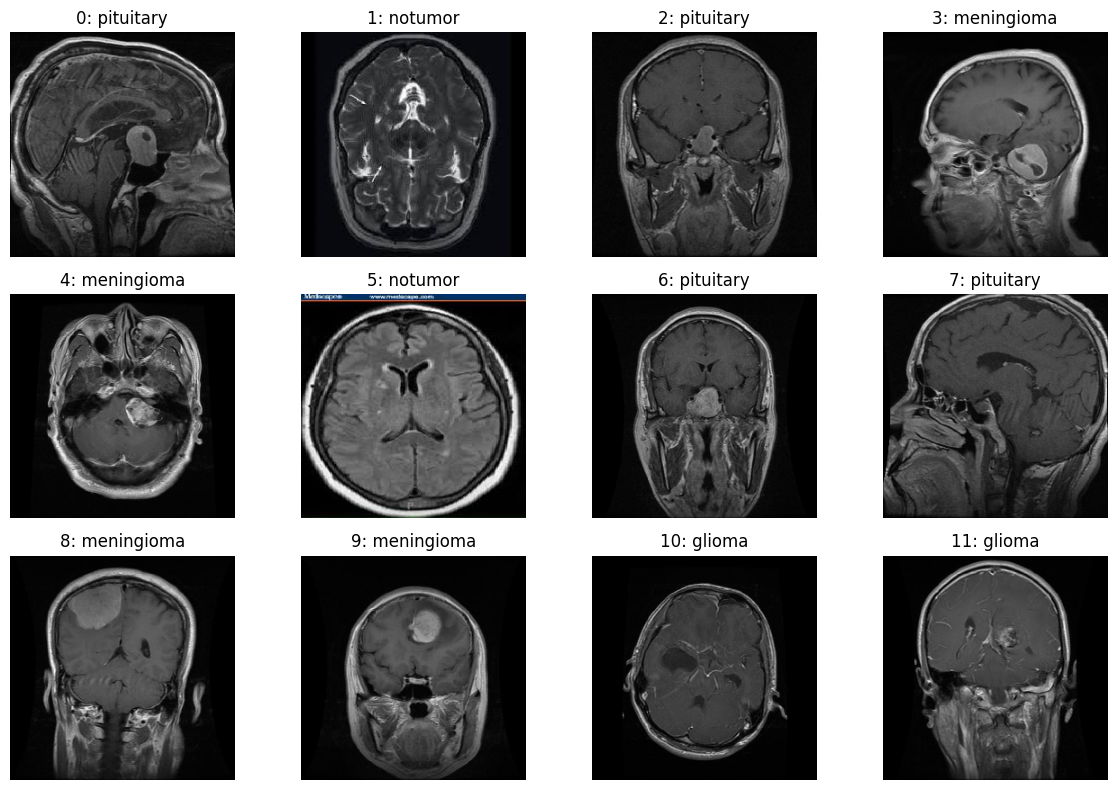

In [5]:
def display_images(path, label_idx, class_namings, index_list=range(10), img_size=250, figsize=(12, 8)):
    """
    Function to display dataset images
    """
    img_count = len(index_list)
    row = (img_count + 3) // 4
    index_to_class = {v: k for k, v in class_namings.items()}
    _, plot_axes = plt.subplots(nrows=row, ncols=4, figsize=figsize)
    plot_axes = plot_axes.flatten()

    for i, indx in enumerate(index_list):
        if i >= img_count or indx >= len(path):
            plot_axes[i].axis('off')
            continue
        img = load_img(path[indx], target_size=(img_size, img_size))
        plot_axes[i].imshow(img)
        class_name = index_to_class[label_idx[indx]]
        plot_axes[i].set_title(f'{indx}: {class_name}')
        plot_axes[i].axis('off')

    for j in range(img_count, len(plot_axes)):
        plot_axes[j].axis('off')

    plt.tight_layout()
    plt.show()

combined_data = list(zip(training_image_paths, training_labels_indx))
random.shuffle(combined_data)
training_image_paths, training_labels_indx = zip(*combined_data)
display_images(training_image_paths, training_labels_indx, class_namings, index_list=range(12))

In [6]:
data_augmentations = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

In [7]:
img_dim = (250, 250)
batch_size = 32

def get_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_dim)
    return img, label

def preprocess_training(image, label):
    img = data_augmentations(image) / 255.0
    return img, label

def preprocess_testing(img, label):
    return img / 255.0, label

training_image_paths = np.array(training_image_paths)
training_labels_indx = np.array(training_labels_indx)
testing_image_paths = np.array(testing_image_paths)
testing_labels_indx = np.array(testing_labels_indx)

train_data = tf.data.Dataset.from_tensor_slices((training_image_paths, training_labels_indx))
train_data = train_data.map(lambda x, y: get_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.map(preprocess_training, num_parallel_calls=tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((testing_image_paths, testing_labels_indx))
test_data = test_data.map(lambda x, y: get_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_testing, num_parallel_calls=tf.data.AUTOTUNE)

train_data_preprocessed = train_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_preprocessed = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

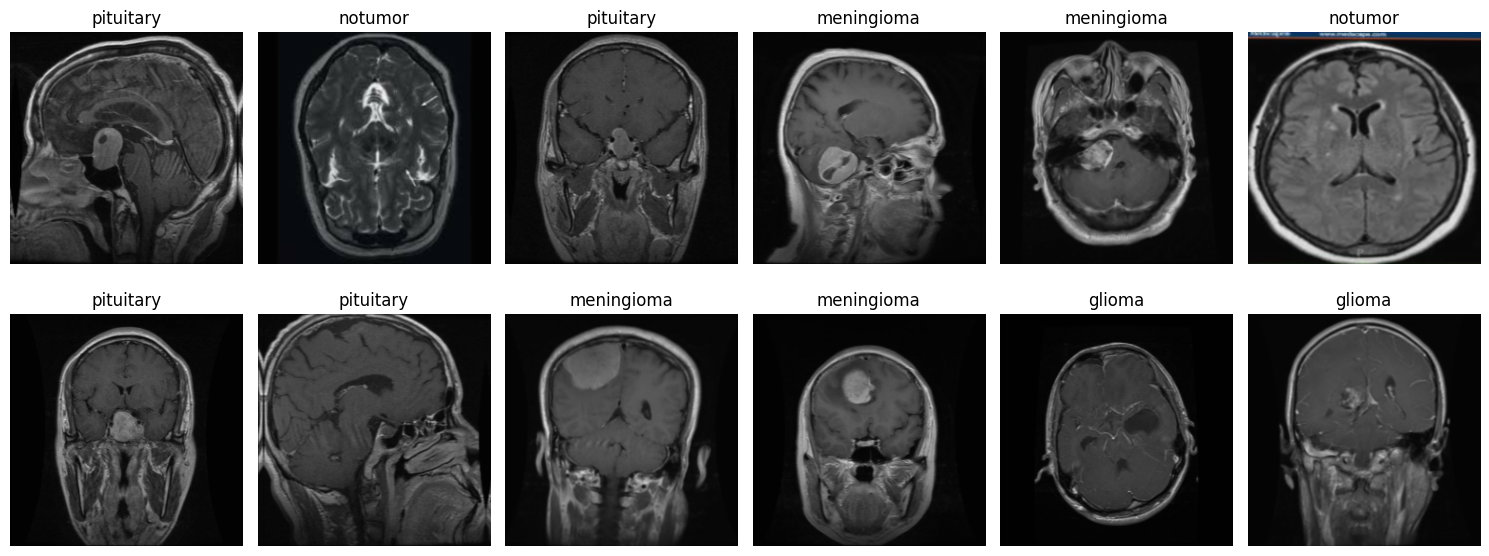

In [8]:
def display_augmented_images(dataset, shape, class_naming, figsize=(15, 6)):
    """
    Function to display augmented images
    """
    plt.figure(figsize=figsize)
    idx_to_class = {v: k for k, v in class_naming.items()}
    for img, label in dataset.take(1):
        for i in range(shape[0] * shape[1]):
            ax = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(img[i].numpy().squeeze())
            plt.title(idx_to_class[label.numpy()[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

display_augmented_images(train_data_preprocessed, shape=(2, 6), class_naming=class_namings)

In [9]:
num_class = len(class_namings.keys())
img_shape = (img_dim[0], img_dim[1], 3)
epoch = 50

inv_class_namings = {v: k for k, v in class_namings.items()}
print(f'Inverse class mappings: {inv_class_namings}')

print(f'Number of Classes: {num_class}')
print(f'Image shape: {img_shape}')
print(f'Epochs: {epoch}')
# print(f'Batch size: {batch_size}')


Inverse class mappings: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
Number of Classes: 4
Image shape: (250, 250, 3)
Epochs: 50


In [10]:
def label_encoder(image, label):
    return image, tf.one_hot(label, depth=num_class)

train_data_preprocessed = train_data_preprocessed.map(label_encoder, num_parallel_calls=tf.data.AUTOTUNE)
test_data_preprocessed = test_data_preprocessed.map(label_encoder, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
def cnn_model_creation(input_shape, num_class):
    """Function to create cnn model"""

    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (5, 5), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(num_class, activation="softmax")
    ])
    return model

In [12]:
input_shape = (img_dim[0], img_dim[1], 3)
cnn_model = cnn_model_creation(input_shape, num_class)
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
class AdjustLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    """
    Callback to adjust learning rate based on multiple accuracies.
    """
    def __init__(self, threshold, factor, monitor='val_accuracy', verbose=1):
        super(AdjustLROnMultipleAccuracies, self).__init__()
        self.threshold = threshold
        self.factor = factor
        self.monitor = monitor
        self.verbose = verbose
        self.threshold_reached = [False] * len(threshold)

    def after_epoch_completion(self, epoch, logs=None):
        epoch_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.threshold):
            if epoch_accuracy >= threshold and not self.threshold_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

In [14]:
thresholds = [0.96, 0.99, 0.9935]
model_file = 'cnn_model.keras'
lr_scheduler = AdjustLROnMultipleAccuracies(threshold=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)
model_lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_checkpoint = ModelCheckpoint(model_file, monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

In [15]:
# Train the model
cnn_history = cnn_model.fit(
    train_data_preprocessed,
    epochs=epoch,
    validation_data=test_data_preprocessed,
    callbacks=[model_lr_reduction, model_checkpoint, lr_scheduler],
    verbose=True
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.5891 - loss: 1.1340 - val_accuracy: 0.7811 - val_loss: 0.5701 - learning_rate: 0.0010
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.8028 - loss: 0.4971 - val_accuracy: 0.8146 - val_loss: 0.4973 - learning_rate: 0.0010
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.8605 - loss: 0.3675 - val_accuracy: 0.8574 - val_loss: 0.3660 - learning_rate: 0.0010
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.8910 - loss: 0.2770 - val_accuracy: 0.9047 - val_loss: 0.2961 - learning_rate: 0.0010
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.9217 - loss: 0.2169 - val_accuracy: 0.9207 - val_loss: 0.2583 - learning_rate: 0.0010
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 146ms/step - accuracy: 0.9409 - loss: 0.1589 - val_accuracy: 0.9314 - val_loss: 0.2531 - learning_rate: 0.0010
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step - accuracy: 0.947

In [64]:
# Load the best model
cnn_model = load_model('cnn_model.keras')

# Evaluate the model on the training set
training_loss, training_accuracy = cnn_model.evaluate(train_data_preprocessed)
print(f"Training accuracy: {training_accuracy*100:.4f}%")

# Evaluate the model on the test set
testing_loss, cnn_testing_accuracy = cnn_model.evaluate(test_data_preprocessed)
print(f"Testing accuracy: {cnn_testing_accuracy*100:.4f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9990 - loss: 0.0029
Training accuracy: 99.9125%
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9932 - loss: 0.0728
Testing accuracy: 99.2372%


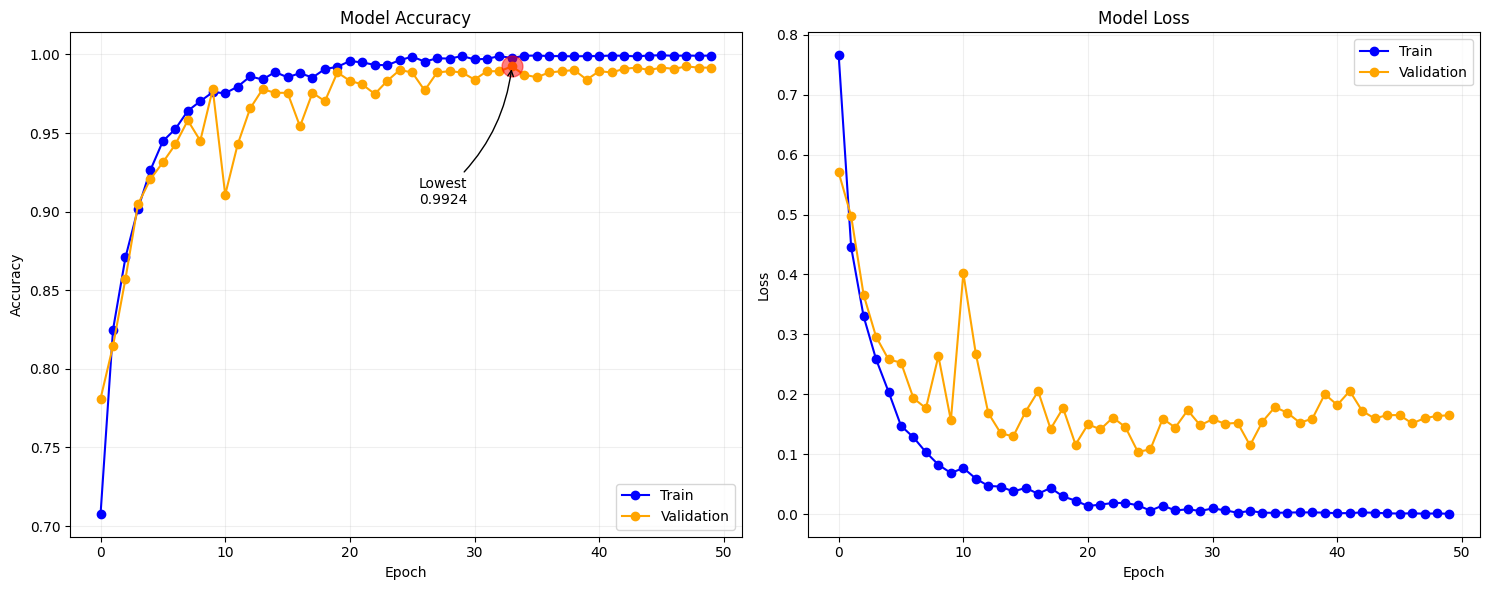

In [17]:
_, plot_axes = plt.subplots(ncols=2, figsize=(15, 6))

# Displaying training and validation accuracy over epochs
plot_axes[0].plot(cnn_history.history['accuracy'], marker='o', linestyle='-', color='blue')
plot_axes[0].plot(cnn_history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
plot_axes[0].set_title('Model Accuracy')
plot_axes[0].set_xlabel('Epoch')
plot_axes[0].set_ylabel('Accuracy')
plot_axes[0].legend(['Train', 'Validation'], loc='lower right')
plot_axes[0].grid(alpha=0.2)

# Displaying training and validation loss over epochs
plot_axes[1].plot(cnn_history.history['loss'], marker='o', linestyle='-', color='blue')
plot_axes[1].plot(cnn_history.history['val_loss'], marker='o', linestyle='-', color='orange')
plot_axes[1].set_title('Model Loss')
plot_axes[1].set_xlabel('Epoch')
plot_axes[1].set_ylabel('Loss')
plot_axes[1].legend(['Train', 'Validation'], loc='upper right')
plot_axes[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(cnn_history.history['val_accuracy'])
min_val_acc = np.max(cnn_history.history['val_accuracy'])
plot_axes[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
plot_axes[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [18]:
# Using test data to make predictions that are true
true_label_list = []
predicted_label_list = []

# Iterate  over the dataset to gather accurate labels and predictions.
for img, lbs in test_data_preprocessed.unbatch():
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(lbs.numpy())
    true_label_list.append(true_label)

    # Get model prediction (predicts batch dimension).
    prediction = cnn_model.predict(tf.expand_dims(img, 0), verbose=False)
    predicted_label = np.argmax(prediction)
    predicted_label_list.append(predicted_label)

In [19]:
def display_confusion_matrix(true_labels, predicted_labels, class_naming, metrics=False, cmap='Blues'):
    """
    Function to determine the confusion matrix
    """

    con_mat = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Index mapping to class names in class_naming
    plt.xticks(ticks=np.arange(num_class) + 0.5, labels=class_naming.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_class) + 0.5, labels=class_naming.keys(), va='center')
    plt.show()

    if metrics:
        # Compute Precision, Recall, and F1-Score for each class & overall accuracy
        precision = np.diag(con_mat) / np.sum(con_mat, axis=0)
        recall = np.diag(con_mat) / np.sum(con_mat, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(con_mat)) / np.sum(con_mat)

        print("Class-wise metrics:")
        for i in range(len(class_naming)):
            class_name = list(class_naming.keys())[i]
            print(f"Class: {class_name}")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"Overall Accuracy: {accuracy:.4f}")

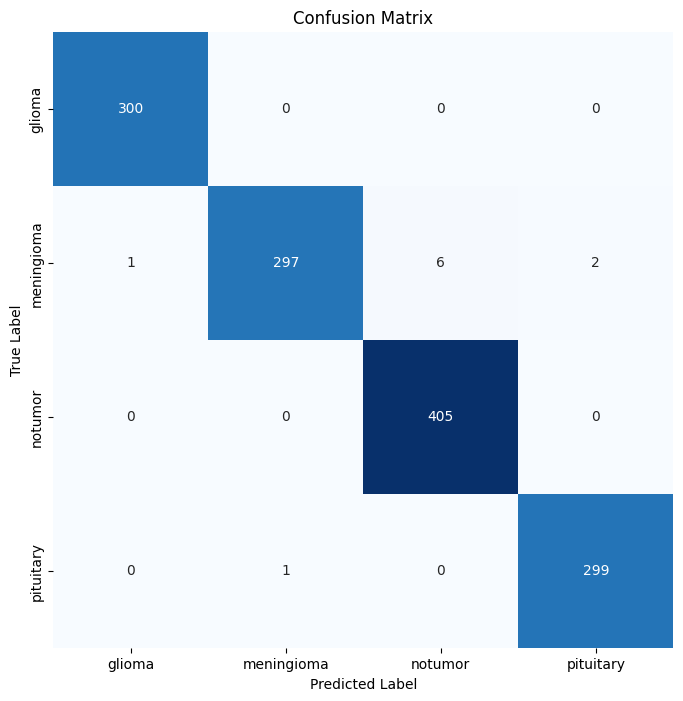

Class-wise metrics:
Class: glioma
Precision: 0.9967
Recall: 1.0000
F1-Score: 0.9983

Class: meningioma
Precision: 0.9966
Recall: 0.9706
F1-Score: 0.9834

Class: notumor
Precision: 0.9854
Recall: 1.0000
F1-Score: 0.9926

Class: pituitary
Precision: 0.9934
Recall: 0.9967
F1-Score: 0.9950

Overall Accuracy: 0.9924


In [20]:
# Display confusion matrix
display_confusion_matrix(true_label_list,
                      predicted_label_list,
                      class_namings,
                      metrics=True)

In [21]:
y_pred_prob = cnn_model.predict(test_data_preprocessed)
y_pred = np.argmax(y_pred_prob, axis=1)

# Step 2: Get the true labels from the test dataset and convert to class indices if needed
y_true = np.concatenate([y for x, y in test_data_preprocessed], axis=0)
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Step 3: Generate and print the classification report
classif_report = classification_report(y_true, y_pred, target_names=inv_class_namings.values())

print("Classification Report:\n")
print(classif_report)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       300
  meningioma       1.00      0.97      0.98       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [22]:
def display_sample_predictions(model, folder_path, indx_to_class, figsize=(10, 10)):
    """
    Displaying the sample images, true labels, and predicted labels.
    """

    plt.figure(figsize=figsize)
    sub_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    img_files = []
    true_labels = []
    for folder in sub_folders:
        subfolder_path = os.path.join(folder_path, folder)
        for img_file in os.listdir(subfolder_path):
            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                img_files.append(os.path.join(subfolder_path, img_file))
                true_labels.append(folder)

    sample_count = len(img_files)
    if sample_count == 0:
        print("No images were located in the designated directory.")
        return

    num_cols = int(np.sqrt(sample_count))
    rows = (sample_count // num_cols) + (sample_count % num_cols > 0)

    for i, img_path in enumerate(img_files):
        sample_img = Image.open(img_path).resize((250, 250))  # Resize to 250x250
        img_array = np.array(sample_img) / 255.0  # Normalize the image
        batch_img = np.expand_dims(img_array, axis=0)

        prediction = model.predict(batch_img, verbose=False)
        predicted_label = np.argmax(prediction, axis=1)[0]
        class_predcition = indx_to_class[predicted_label]

        true_class = true_labels[i]

        plt.subplot(rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPredicted: {class_predcition}", color='green')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


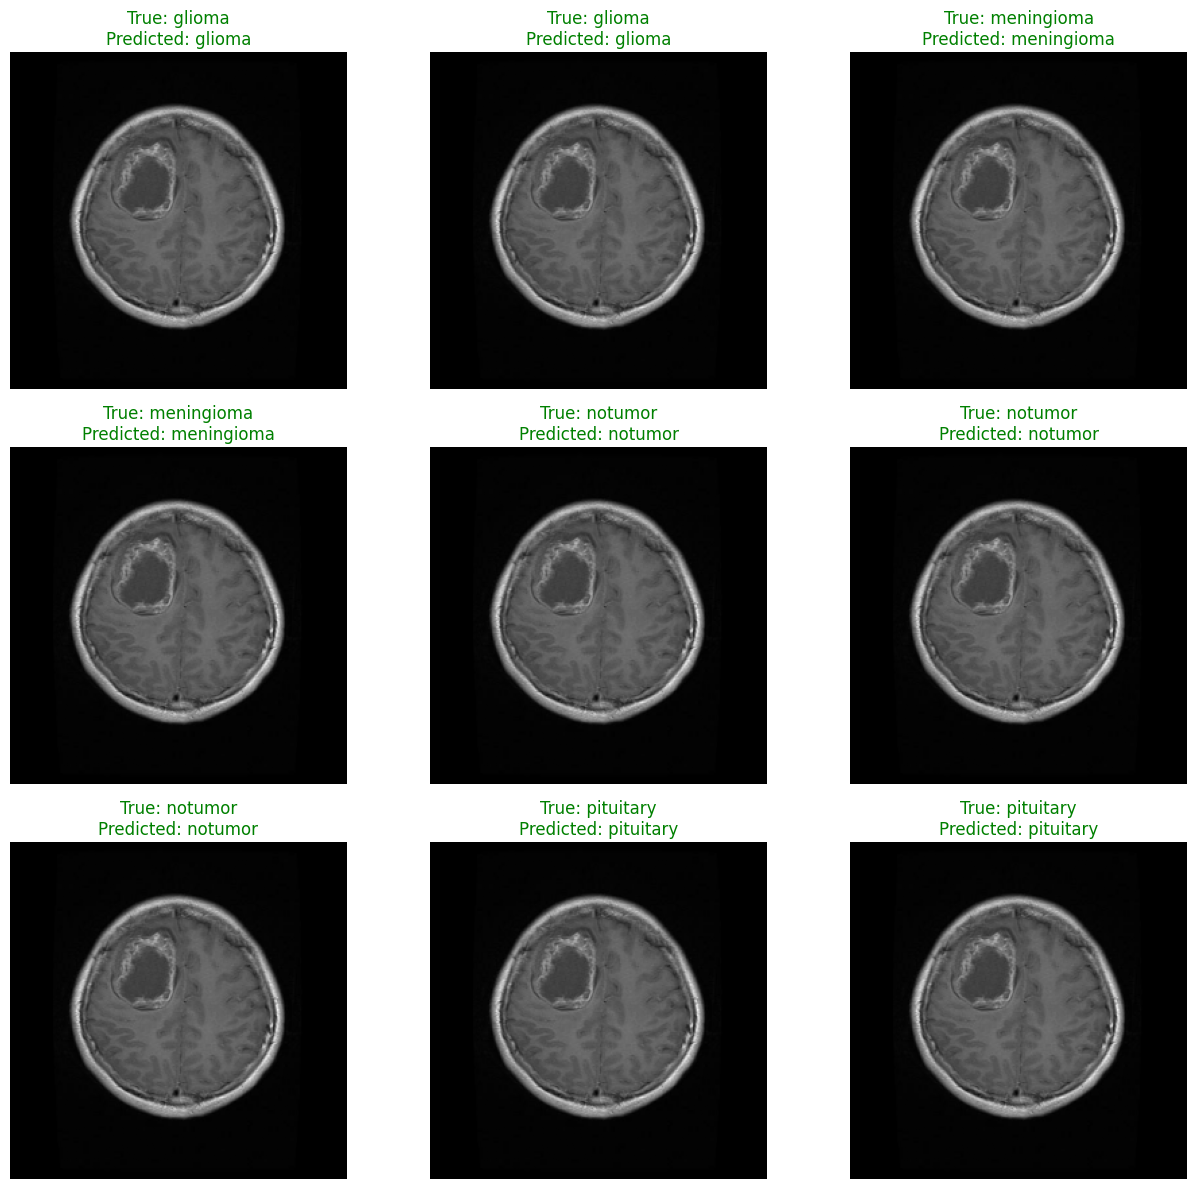

In [23]:
# Display samples with predictions
prediction_dir = '/content/drive/MyDrive/Final project/ImagePrediction'
display_sample_predictions(cnn_model, prediction_dir, inv_class_namings, figsize=(13, 12))

In [24]:
def display_misclassified_samples(model, dataset, indx_to_class, figsize=(10, 10)):
    """
    Display misclassified samples from test data
    """

    misclassified_image_list = []
    misclassified_label_list = []
    misclassified_prediction_list = []

    # Iterate over dataset to gather misclassified images
    for img, true_label in dataset.unbatch():
        batch_img = tf.expand_dims(img, 0)
        model_prediction = model.predict(batch_img, verbose=False)
        predicted_label = np.argmax(model_prediction, axis=1)[0]
        true_class_idx = np.argmax(true_label.numpy())

        if true_class_idx != predicted_label:
            misclassified_image_list.append(img.numpy().squeeze())
            misclassified_label_list.append(indx_to_class[true_class_idx])
            misclassified_prediction_list.append(indx_to_class[predicted_label])

    # Compute number of rows and columns for subplot
    misclassified_count = len(misclassified_image_list)
    cols = int(np.sqrt(misclassified_count)) + 1
    rows = misclassified_count // cols + (misclassified_count % cols > 0)

    # Displaying misclassified images
    misclassified_zip = zip(misclassified_image_list, misclassified_label_list, misclassified_prediction_list)
    plt.figure(figsize=figsize)
    for i, (image, true_label, predicted_label) in enumerate(misclassified_zip):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

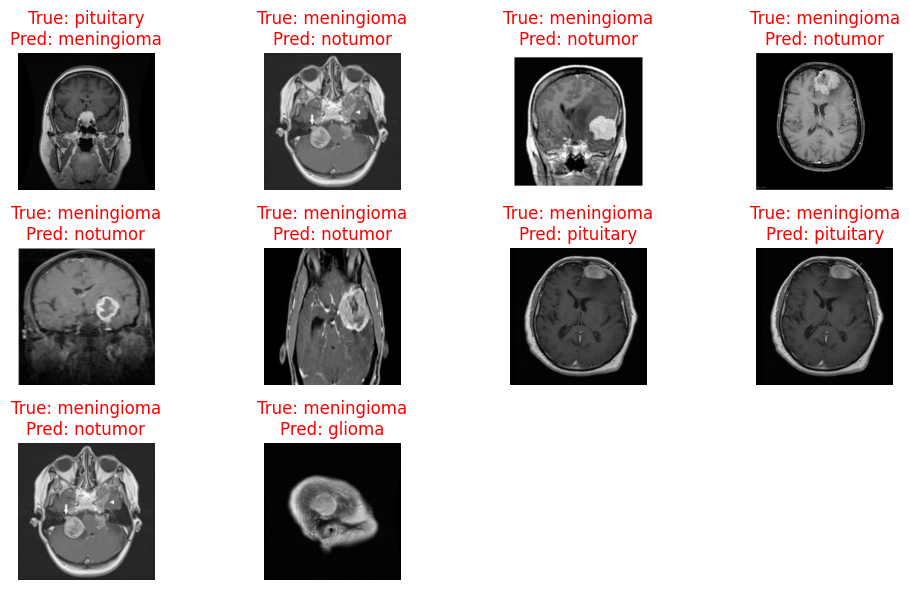

In [25]:
# Display misclassified samples
display_misclassified_samples(model=cnn_model,
                           dataset=test_data_preprocessed,
                           indx_to_class=inv_class_namings,
                           figsize=(10, 6))

**Model: CNN-VGG16**

In [26]:
# Create CNN-VGG16 model
def vgg16_cnn_model(input_shape, num_class):
    """Create vgg16-cnn model"""

    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    # Freeze all the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers of the base model
    base_model.layers[-2].trainable = True
    base_model.layers[-3].trainable = True
    base_model.layers[-4].trainable = True

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_class, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [27]:
input_shape = (img_dim[0], img_dim[1], 3)
epoch = 10
vgg16_model = vgg16_cnn_model(input_shape, num_class)
optimizer = Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

thresholds = [0.96, 0.99, 0.9935]
vgg16_cnn_model_file = 'cnn_vgg16_model.keras'
lr_scheduler = AdjustLROnMultipleAccuracies(threshold=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)
model_lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_checkpoint = ModelCheckpoint(vgg16_cnn_model_file, monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
# Train the model
vgg16_cnn_history = vgg16_model.fit(
    train_data_preprocessed,
    epochs=epoch,
    validation_data=test_data_preprocessed,
    callbacks=[model_lr_reduction, model_checkpoint, lr_scheduler],
    verbose=True
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 319ms/step - accuracy: 0.7375 - loss: 0.6561 - val_accuracy: 0.8841 - val_loss: 0.3438 - learning_rate: 1.0000e-04
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.9151 - loss: 0.2225 - val_accuracy: 0.9108 - val_loss: 0.2807 - learning_rate: 1.0000e-04
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.9474 - loss: 0.1464 - val_accuracy: 0.9367 - val_loss: 0.1975 - learning_rate: 1.0000e-04
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.9646 - loss: 0.0942 - val_accuracy: 0.9390 - val_loss: 0.1942 - learning_rate: 1.0000e-04
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 196ms/step - accuracy: 0.9721 - loss: 0.0777 - val_accuracy: 0.9695 - val_loss: 0.1076 - learning_rate: 1.0000e-04
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.9794 - loss: 0.0640 - val_accuracy: 0.9550 - val_loss: 0.1315 - learning_rate: 1.0000e-04
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 19

In [65]:
# Load the vgg16-cnn model
vgg16_cnn = load_model(vgg16_cnn_model_file)

training_loss, training_accuracy = vgg16_cnn.evaluate(train_data_preprocessed)
print(f"Training accuracy: {training_accuracy*100:.4f}%")

testing_loss, cnn_vgg16_testing_accuracy = vgg16_cnn.evaluate(test_data_preprocessed)
print(f"Testing accuracy: {cnn_vgg16_testing_accuracy*100:.4f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.9958 - loss: 0.0141
Training accuracy: 99.5973%
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9956 - loss: 0.0162
Testing accuracy: 98.1693%


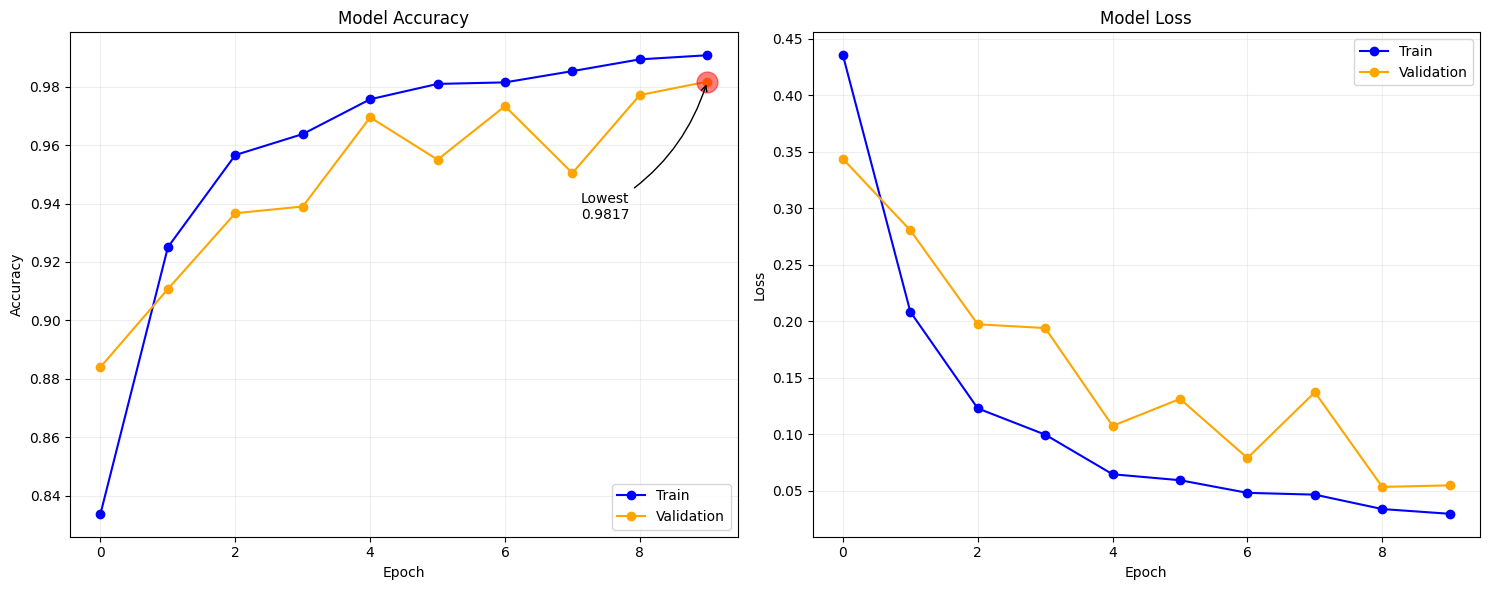

In [30]:
_, plot_axes = plt.subplots(ncols=2, figsize=(15, 6))

# Displaying training and validation accuracy over epochs
plot_axes[0].plot(vgg16_cnn_history.history['accuracy'], marker='o', linestyle='-', color='blue')
plot_axes[0].plot(vgg16_cnn_history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
plot_axes[0].set_title('Model Accuracy')
plot_axes[0].set_xlabel('Epoch')
plot_axes[0].set_ylabel('Accuracy')
plot_axes[0].legend(['Train', 'Validation'], loc='lower right')
plot_axes[0].grid(alpha=0.2)

# Diplaying training and validation loss over epochs
plot_axes[1].plot(vgg16_cnn_history.history['loss'], marker='o', linestyle='-', color='blue')
plot_axes[1].plot(vgg16_cnn_history.history['val_loss'], marker='o', linestyle='-', color='orange')
plot_axes[1].set_title('Model Loss')
plot_axes[1].set_xlabel('Epoch')
plot_axes[1].set_ylabel('Loss')
plot_axes[1].legend(['Train', 'Validation'], loc='upper right')
plot_axes[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(vgg16_cnn_history.history['val_accuracy'])
min_val_acc = np.max(vgg16_cnn_history.history['val_accuracy'])
plot_axes[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
plot_axes[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [31]:
true_label_list = []
predicted_label_list = []

# Iterate over dataset to gather predictions and true labels
for img, lab in test_data_preprocessed.unbatch():
    true_label = np.argmax(lab.numpy())
    true_label_list.append(true_label)

    prediction = vgg16_cnn.predict(tf.expand_dims(img, 0), verbose=False)
    predicted_label = np.argmax(prediction)
    predicted_label_list.append(predicted_label)

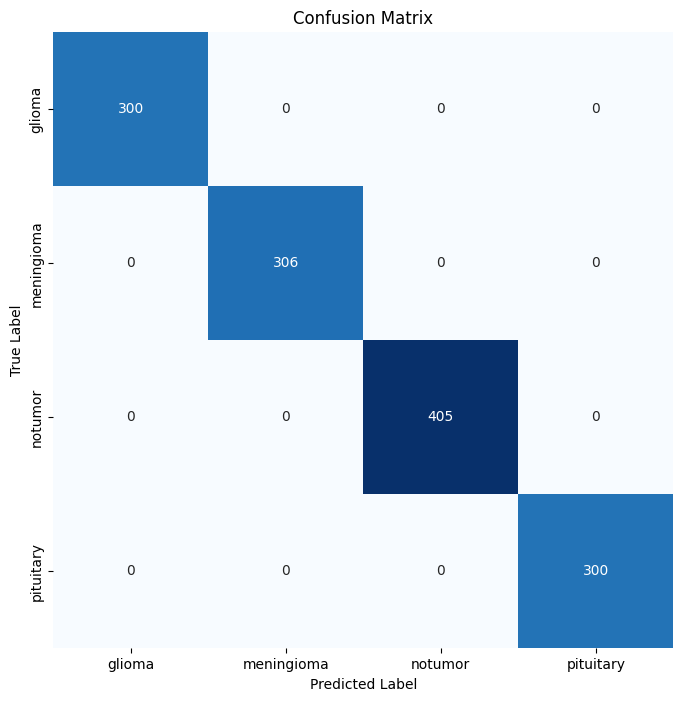

Class-wise metrics:
Class: glioma
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Class: meningioma
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Class: notumor
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Class: pituitary
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Overall Accuracy: 1.0000


In [32]:
# Display confusion matrix for VGG16 Model
display_confusion_matrix(true_label_list, true_label_list, class_namings, metrics=True)

In [33]:
y_pred_prob = vgg16_cnn.predict(test_data_preprocessed)
y_pred = np.argmax(y_pred_prob, axis=1)

# Step 2: Get the true labels from the test dataset and convert to class indices if needed
y_true = np.concatenate([y for x, y in test_data_preprocessed], axis=0)
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Step 3: Generate and print the classification report
classif_report = classification_report(y_true, y_pred, target_names=inv_class_namings.values())

print("Classification Report:\n")
print(classif_report)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98       300
  meningioma       0.97      0.96      0.97       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



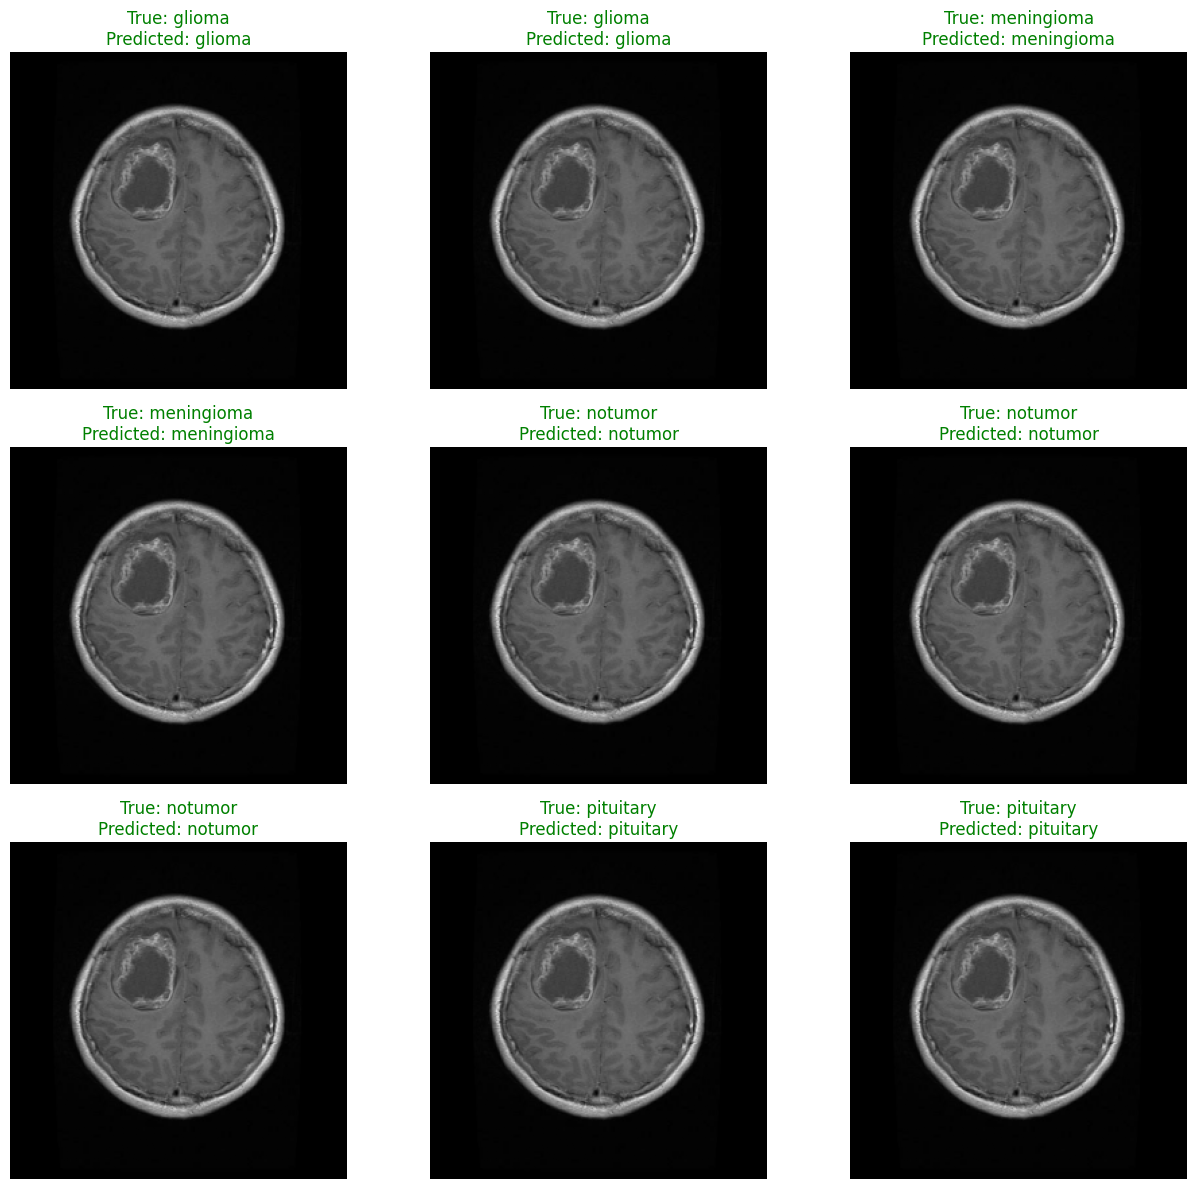

In [34]:
# Plot sample predictions for VGG16 Model
prediction_folder = '/content/drive/MyDrive/Final project/ImagePrediction'
display_sample_predictions(vgg16_cnn, prediction_folder, inv_class_namings, figsize=(13, 12))

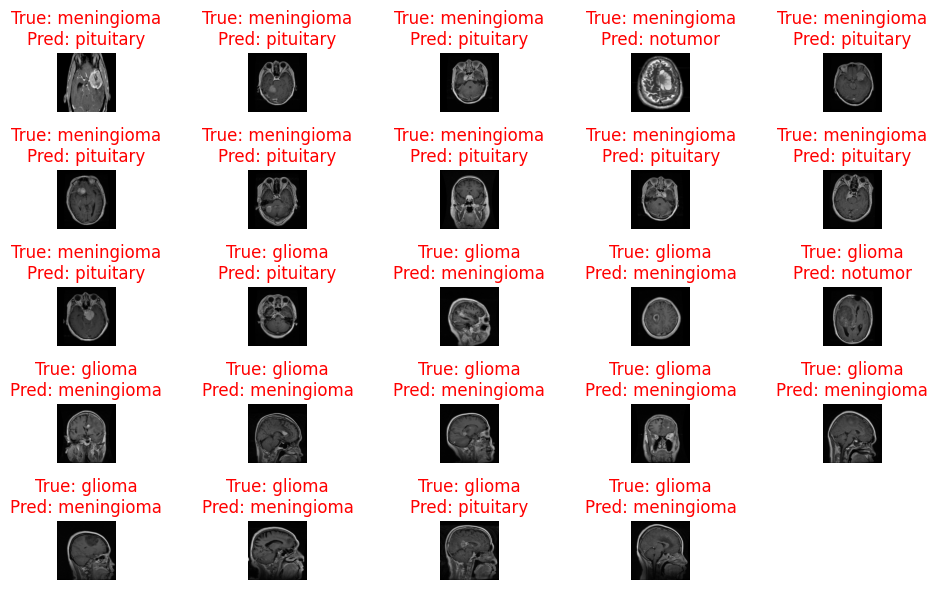

In [35]:
# Display samples with predictions
display_misclassified_samples(
    model=vgg16_cnn,
    dataset=test_data_preprocessed,
    indx_to_class=inv_class_namings,
    figsize=(10, 6)
    )

**Model: KNN**

In [36]:
def preprocess_data_images(image_path, image_size=(250, 250)):
    """
    Function to preprocess the images for machine learning model
    """
    image = load_img(image_path, target_size=image_size)
    image_array = img_to_array(image).flatten() / 255.0  # Flatten the image and normalize
    return image_array

In [37]:
X_train = np.array([preprocess_data_images(img_path) for img_path in training_image_paths])
y_train = np.array(training_labels_indx)

X_test = np.array([preprocess_data_images(img_path) for img_path in testing_image_paths])
y_test = np.array(testing_labels_indx)

In [66]:
# Create and train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Save the model
joblib.dump(knn_model, 'knn_model.pkl')

# Predict based on the training set to determine training accuracy
y_train_prediction = knn_model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_prediction)
print(f"Training Accuracy: {training_accuracy*100:.2f}%")

# Predict based on the test set in order to determine test accuracy.
y_pred_knn = knn_model.predict(X_test)
knn_test_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy: {knn_test_accuracy*100:.2f}%")

Training Accuracy: 92.77%
Test Accuracy: 84.90%


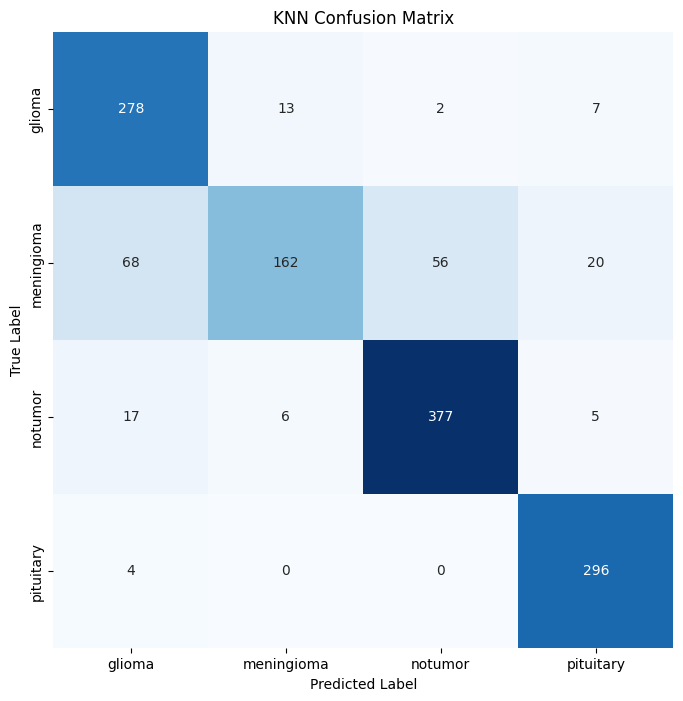

Classification Report:

              precision    recall  f1-score   support

      glioma       0.76      0.93      0.83       300
  meningioma       0.90      0.53      0.67       306
     notumor       0.87      0.93      0.90       405
   pituitary       0.90      0.99      0.94       300

    accuracy                           0.85      1311
   macro avg       0.86      0.84      0.83      1311
weighted avg       0.86      0.85      0.84      1311



In [39]:
# Display confusion matrix for knn model
con_mat_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_knn, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=class_namings.keys(), yticklabels=class_namings.keys())
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

classif_report = classification_report(y_test, y_pred_knn, target_names=class_namings.keys())
print("Classification Report:\n")
print(classif_report)

In [40]:
def display_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Function to plot the learning curve for the model
    """
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    trainiing_sizes, training_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    training_scores_mean = np.mean(training_scores, axis=1)
    training_scores_std = np.std(training_scores, axis=1)
    testing_scores_mean = np.mean(test_scores, axis=1)
    testing_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, training_scores_mean - training_scores_std, training_scores_mean + training_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, testing_scores_mean - testing_scores_std, testing_scores_mean + testing_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, training_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, testing_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


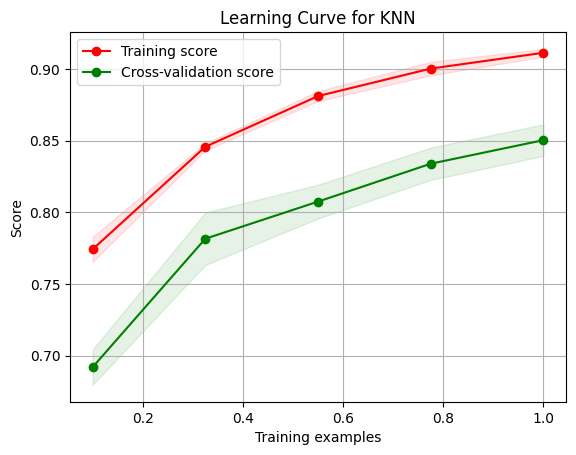

In [41]:
# Plot learning curve for knn model
display_learning_curve(knn_model, "Learning Curve for KNN", X_train, y_train, cv=5)
plt.show()

In [42]:
def predict_tumor_type(image_array, model, class_naming):
    """
    Function to predict the tumor type for sample image
    """
    image_array = image_array.reshape(1, -1)
    prediction = model.predict(image_array)

    # Decode the prediction to determine the type of tumor.
    inv_class_naming = {v: k for k, v in class_naming.items()}
    tumor_type = inv_class_naming[prediction[0]]
    return tumor_type

def display_predictions(model, folder_path, class_naming, image_size=(250, 250), figsize=(13, 12)):
    """
    Function to plot predictions for all images in the prediction folder
    """
    image_path_list = []
    true_label_list = []

    # Collect image paths and corresponding labels
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_file in os.listdir(class_folder):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path_list.append(os.path.join(class_folder, img_file))
                    true_label_list.append(class_name)

    sample_count = len(image_path_list)
    rows = int(np.sqrt(sample_count))
    num_cols = (sample_count // rows) + (sample_count % rows > 0)

    plt.figure(figsize=figsize)

    for i in range(sample_count):
        img_path = image_path_list[i]
        true_label = true_label_list[i]
        img_array = preprocess_data_images(img_path, image_size=image_size)
        predicted_label = predict_tumor_type(img_array, model, class_naming)

        plt.subplot(rows, num_cols, i + 1)
        plt.imshow(img_array.reshape(image_size[0], image_size[1], 3))
        title_color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

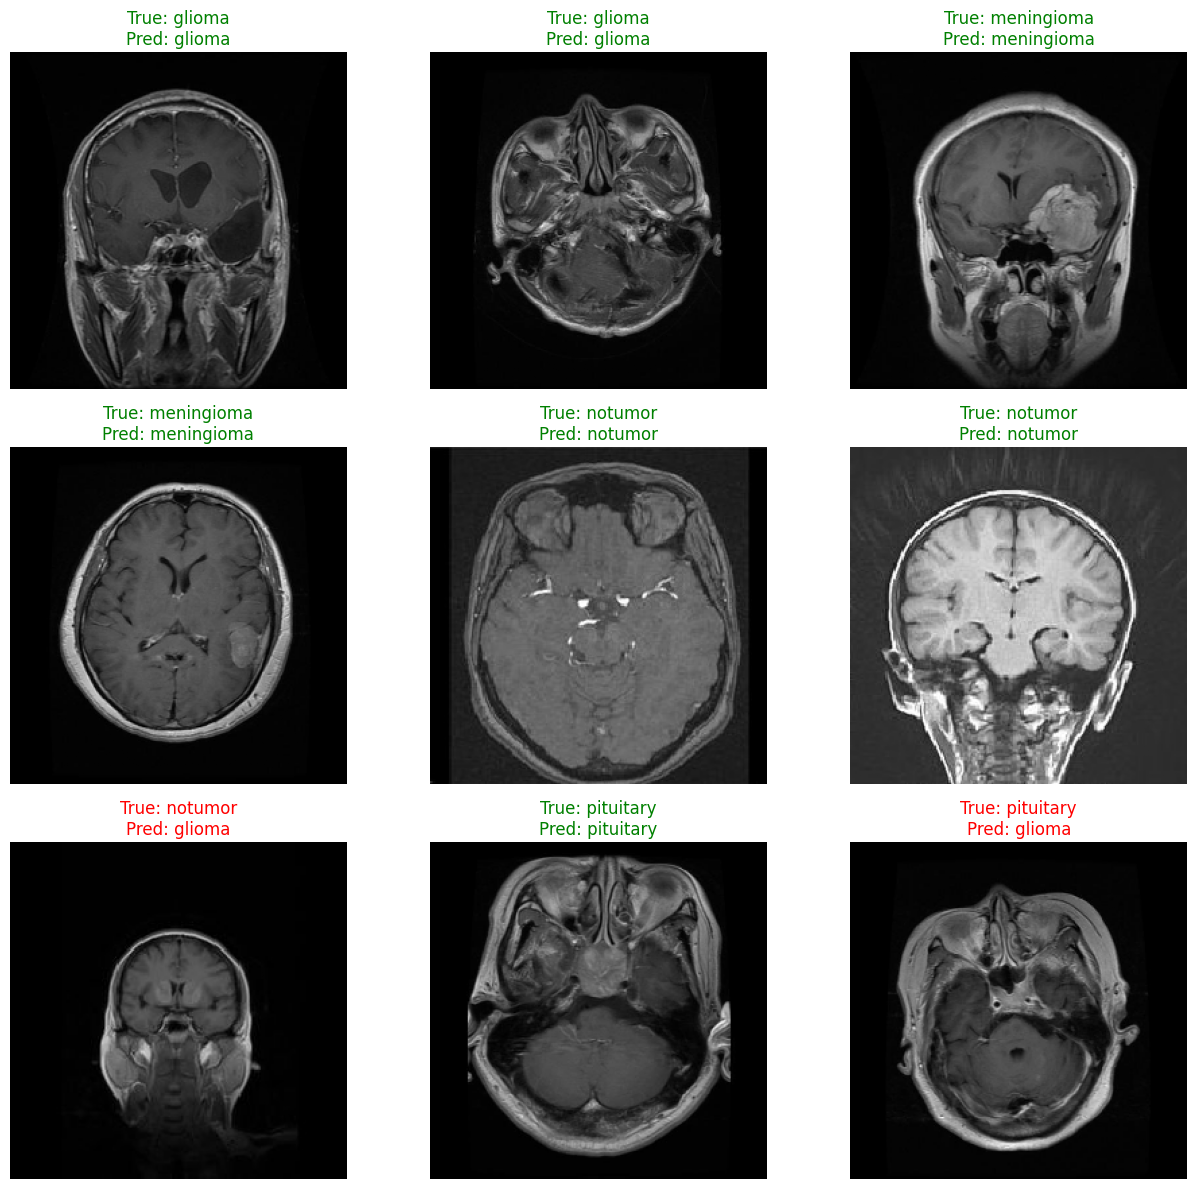

In [43]:
# Predict and display the sample images for knn model
prediction_folder = '/content/drive/MyDrive/Final project/ImagePrediction'
knn_model = joblib.load('knn_model.pkl')
display_predictions(knn_model, prediction_folder, class_namings)

Model: RandomForest

In [44]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

# Save the model
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [45]:
rf_model_file = joblib.load('random_forest_model.pkl')
y_prediction_rf = rf_model.predict(X_test)

# Predict on the training set to compute training accuracy
y_train_pred_rf = rf_model.predict(X_train)
training_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print(f"Training Accuracy: {training_accuracy_rf*100:.4f}%")

# Predict on the test set to compute testing accuracy
testing_accuracy_rf = accuracy_score(y_test, y_prediction_rf)
print(f"Test Accuracy: {testing_accuracy_rf*100:.4f}%")

print("Classification Report:")
print(classification_report(y_test, y_prediction_rf, target_names=class_namings.keys()))

Training Accuracy: 100.0000%
Test Accuracy: 93.6690%
Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.83      0.89       300
  meningioma       0.85      0.92      0.88       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.95      0.98      0.96       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



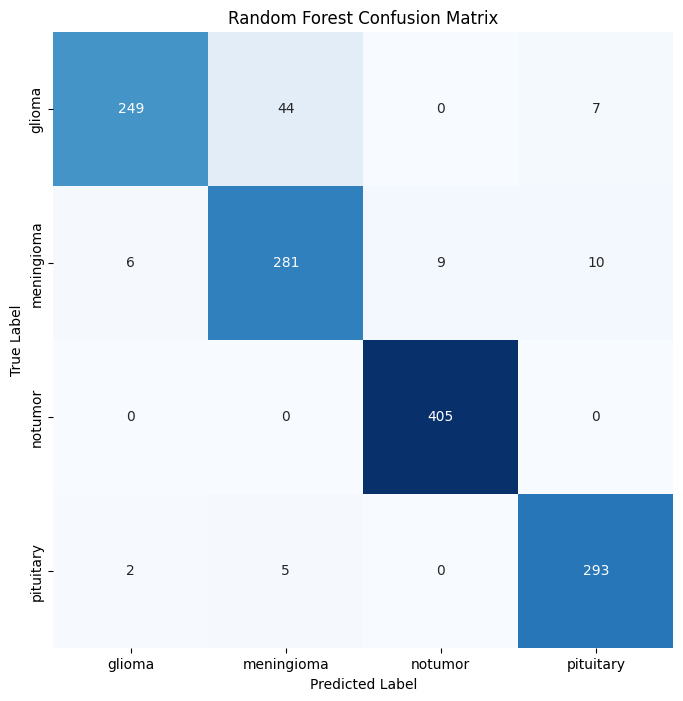

In [46]:
# Display confusion matrix fro random forest
con_mat_rf = confusion_matrix(y_test, y_prediction_rf)

plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_rf, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=class_namings.keys(), yticklabels=class_namings.keys())
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

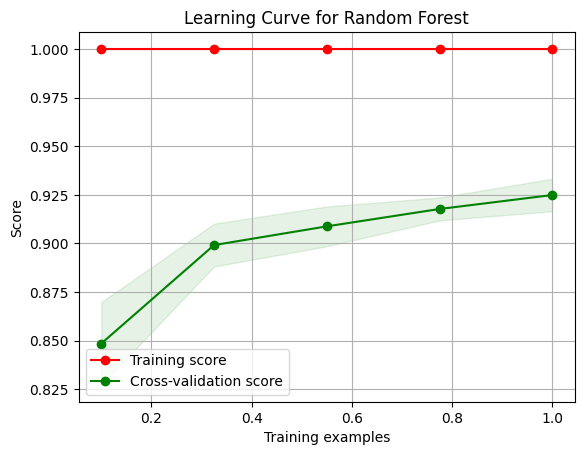

In [48]:
# Plot learning curve for random forest model
display_learning_curve(rf_model, "Learning Curve for Random Forest", X_train, y_train, cv=5)
plt.show()

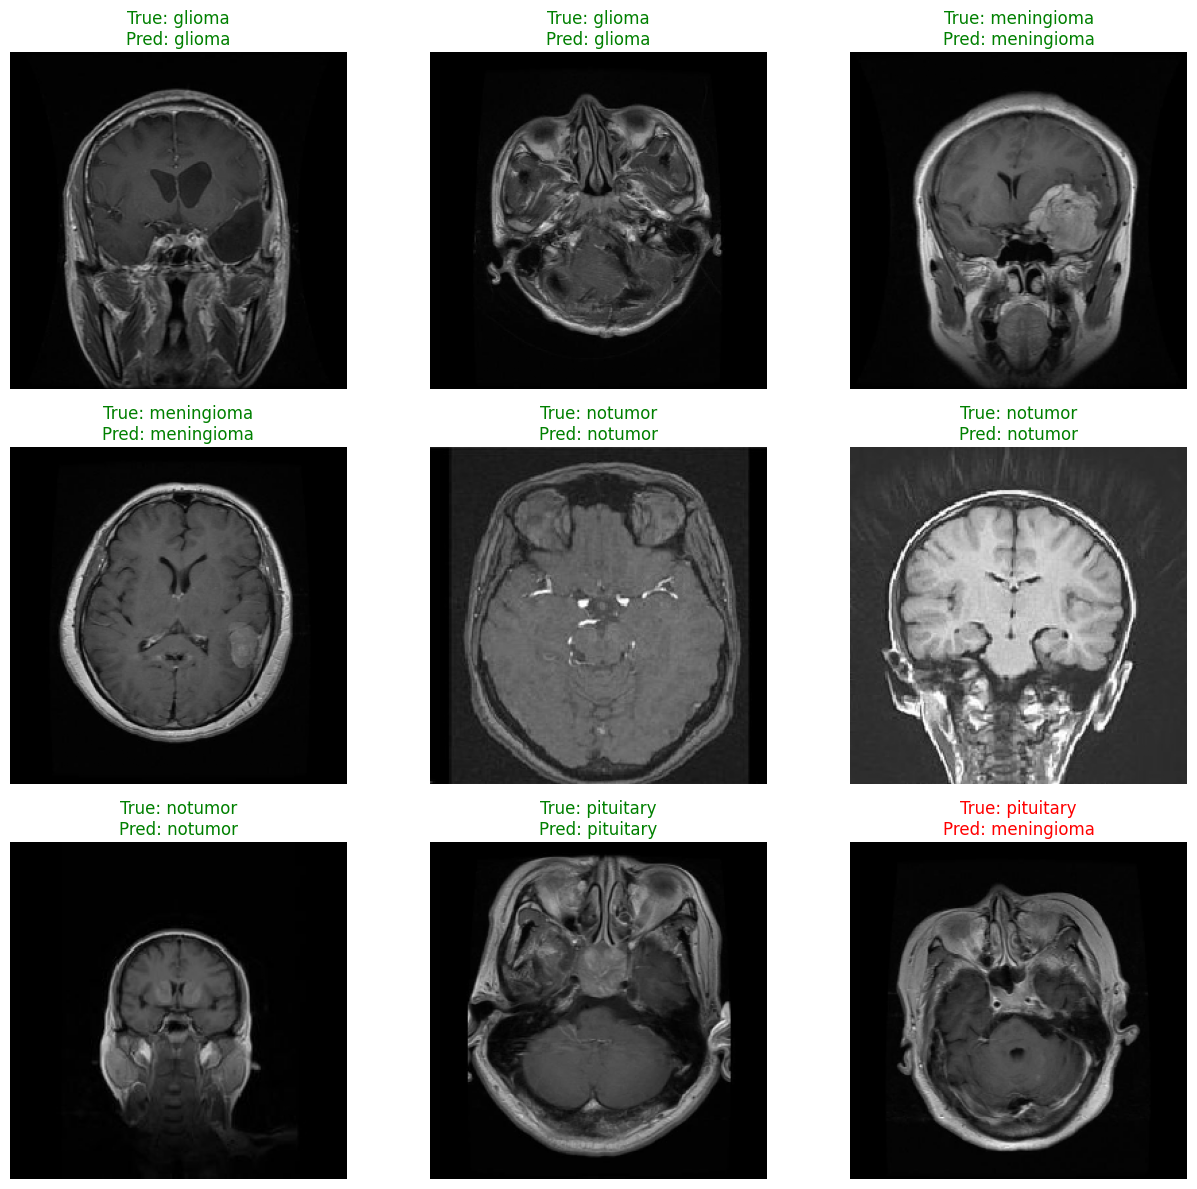

In [49]:
# Predict and display the sample images for random forest model
prediction_folder = '/content/drive/MyDrive/Final project/ImagePrediction'
rf_model = joblib.load('random_forest_model.pkl')
display_predictions(rf_model, prediction_folder, class_namings)

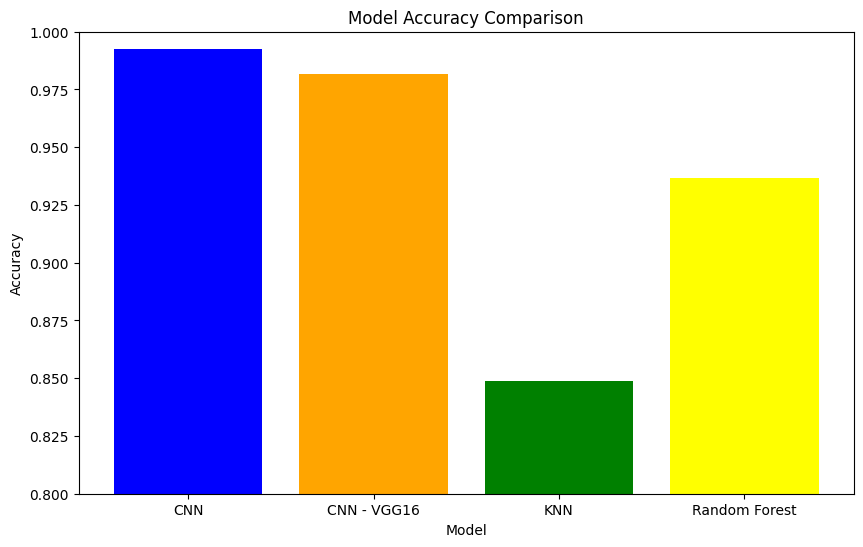

In [74]:
accuracies = {
    'CNN': cnn_testing_accuracy,
    'CNN - VGG16': cnn_vgg16_testing_accuracy,
    'KNN': knn_test_accuracy,
    'Random Forest': testing_accuracy_rf
}

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'orange', 'green', 'yellow'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.8,1)
plt.show()

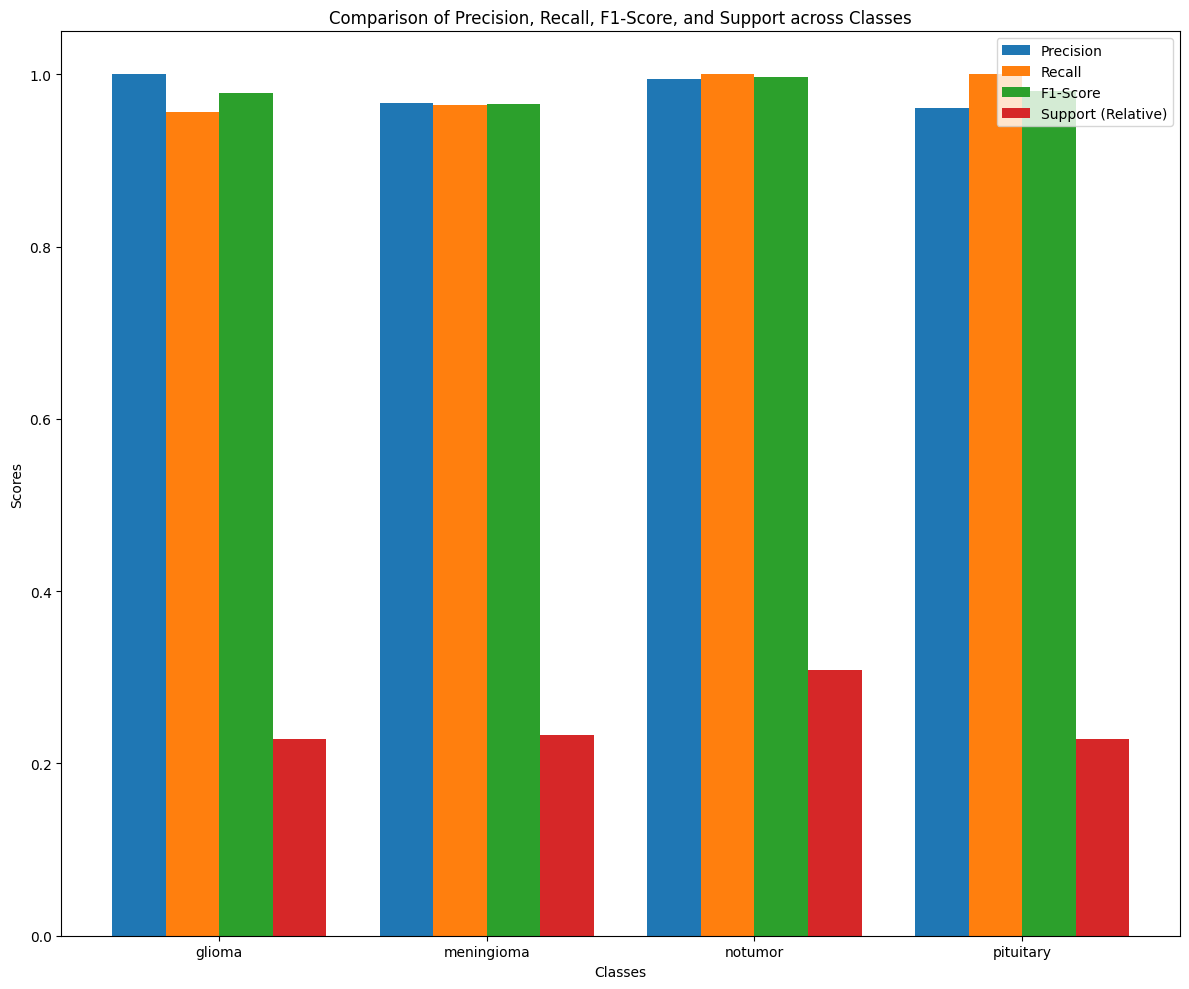

In [78]:


# Assuming true_labels and predicted_labels are defined
# Also assuming class_naming is a dictionary that maps indices to class names

# Generate classification report
report = classification_report(true_label_list, predicted_label_list, target_names=list(class_namings.keys()), output_dict=True)

# Extract metrics from the classification report
precision = [report[class_name]['precision'] for class_name in class_namings.keys()]
recall = [report[class_name]['recall'] for class_name in class_namings.keys()]
f1_score = [report[class_name]['f1-score'] for class_name in class_namings.keys()]
support = [report[class_name]['support'] for class_name in class_namings.keys()]
classes = list(class_namings.keys())

# Convert support to a relative value (percentage) if needed
support_percentage = np.array(support) / np.sum(support)

# Set up the bar width and positions
bar_width = 0.2
index = np.arange(len(classes))

# Plotting
plt.figure(figsize=(12, 10))

plt.bar(index, precision, bar_width, label='Precision')
plt.bar(index + bar_width, recall, bar_width, label='Recall')
plt.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score')
plt.bar(index + 3 * bar_width, support_percentage, bar_width, label='Support (Relative)')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Comparison of Precision, Recall, F1-Score, and Support across Classes')
plt.xticks(index + 1.5 * bar_width, classes)
plt.legend()

plt.tight_layout()
plt.show()
